<img src="img/TJI_logo_whitebg_440x220.jpg" alt="drawing" style="width: 220px;float: right"/>

# Analysis: What kinds of officers are involved in shootings?
---

## Overview
An examination of the categories of police officers that are disproportionately represented in officer-involved shootings.

## IMPORTANT NOTES
* Simply because one demographic of officer is involved in more shootings does **not** mean they are more dangerous or more prone to escalation. For example, lower-ranking officers are more likely to be out on patrol in general, and thus should show up more often in shootings, even if they are just as good at de-escalation as higher-ranking officers.

## Summary of findings
* Younger officers are a more likely to be involved in shootings.
* Men comprise 88% of the Texas police force, but 97% of the officers involved in shootings
* The fact that there are more women among younger officers makes this statistic even more striking.

## Datasets used:
* `tji/officer-involved-shootings/shot_civilians.csv`
* `tji/auxiliary-datasets/list_of_texas_officers`

##### Author: Everett Wetchler (everett.wetchler@gmail.com)

## [ Setup and load data ]

In [1]:
from scipy import stats
from lib import PlotSaver, percentify_x, percentify_y, test_summary

plotsaver = PlotSaver('../plots/', 'ois_which_officers_')

Removing 2 past plots


/Users/everettwetchler/.virtualenvs/tji-analysis/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Everett Wetchler 2018-05-24 13:46:57 CDT

numpy 1.14.3
pandas 0.20.1
matplotlib 2.2.0
seaborn 0.7.1
datadotworld 1.6.0
Git hash: 20251e6910494b3fa13a9f8e2e3f9bcecef4682f
watermark 1.5.0


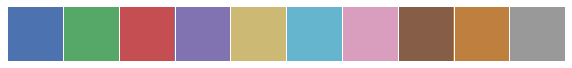

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

import datetime as dt
import os
import random

import datadotworld as dw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## Jupyter setup
%matplotlib inline

## Graphical setup
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# Set up a longer default color palette of very different
# colors for plotting categorical data.
set1 = sns.color_palette('Set1', 9, desat=.5)
super_palette = sns.color_palette('deep', 6) + [set1[7], set1[6], set1[4], set1[8]]
sns.set_palette(super_palette)
sns.palplot(sns.color_palette())

# It's useful to have some named colors handy
(SNS_BLUE, SNS_GREEN, SNS_RED,
 SNS_PURPLE, SNS_YELLOW, SNS_CYAN,
 SNS_PINK, SNS_BROWN, SNS_ORANGE,
 SNS_GRAY) = super_palette

# Watermark extension to print version/system information
# Flags:
# -a [author] -d (date) -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version) -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -g -d -t -z -w -p numpy,pandas,matplotlib,seaborn,datadotworld

####################################################
# END Boilerplate
####################################################

In [3]:
def long_gender_name(g):
    if pd.isnull(g):
        return g
    return 'MALE' if g.startswith('M') else 'FEMALE'

In [4]:
datasets = dw.load_dataset('tji/officer-involved-shootings', force_update=True)
shot_civ = datasets.dataframes['shot_civilians']
shot_civ.head()

,date_incident,incident_address,incident_city,incident_county,incident_zip,incident_longitude,incident_latitude,incident_census_tract,incident_result_of,incident_call_other,civilian_name_first,civilian_name_last,civilian_name_full,civilian_gender,civilian_age,civilian_race,civilian_died,officer_age_1,officer_race_1,officer_gender_1,agency_name_1,agency_report_date_1,agency_city_1,agency_county_1,agency_zip_1,agency_name_person_filling_out_1,agency_email_person_filling_out_1,officer_age_2,officer_race_2,officer_gender_2,officer_caused_injury_2,agency_name_2,agency_report_date_2,agency_city_2,agency_county_2,agency_zip_2,agency_name_person_filling_out_2,agency_email_person_filling_out_2,officer_age_3,officer_race_3,officer_gender_3,officer_caused_injury_3,agency_name_3,agency_report_date_3,agency_city_3,agency_county_3,agency_zip_3,agency_name_person_filling_out_3,agency_email_person_filling_out_3,officer_age_4,...,agency_name_person_filling_out_7,agency_email_person_filling_out_7,officer_age_8,officer_race_8,officer_gender_8,agency_name_8,agency_report_date_8,agency_city_8,agency_county_8,agency_zip_8,agency_name_person_filling_out_8,agency_email_person_filling_out_8,officer_age_9,officer_race_9,officer_gender_9,agency_name_9,agency_report_date_9,agency_city_9,agency_county_9,agency_zip_9,agency_name_person_filling_out_9,agency_email_person_filling_out_9,officer_age_10,officer_race_10,officer_gender_10,agency_name_10,agency_report_date_10,agency_city_10,agency_county_10,agency_zip_10,agency_name_person_filling_out_10,agency_email_person_filling_out_10,news_coverage_1,news_coverage_2,news_coverage_3,news_coverage_4,cdr_narrative,custodial_death_report,deadly_weapon,deadly_weapon_category,deadly_weapon_description,lea_narrative_published,lea_narrative_shorter,multiple_officers_involved,num_officers_recorded,num_reports_filed,num_rows_about_this_incident,officer_on_duty,time_incident,incident_location
0,2015-09-02,1010 MAGNOLIA STREET,FREEPORT,BRAZORIA,77541.0,-95.356262,28.944891,664400.0,TRAFFIC STOP,NARCOTIC STOP AND EVADING ARREST,RICKEY,MAYBERRY,RICKEY MAYBERRY,M,30.0,BLACK,False,27.0,HISPANIC,M,FREEPORT POLICE DEPT,9/16/2015,FREEPORT,BRAZORIA,77541,PAMELA MORRIS,PMORRIS@FREEPORT.TX.US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,ABC 13,YOUR SOUTHEST TEXAS,NaN,NaN,NaN,False,False,NaN,NaN,NaN,NaN,True,1,1,1,True,NaN,POINT(-95.3562616 28.9448909)
1,2015-09-03,4840 E. PLANO PARKWAY,PLANO,COLLIN,75074.0,-96.642308,33.008128,32010.0,OTHER - SPECIFY TYPE OF CALL,ACCIDENTAL DISCHARGE RICOCHET DURING RANGE ACT...,NaN,NaN,NaN,M,55.0,WHITE,False,30.0,HISPANIC,M,PLANO POLICE DEPT,10/1/2015,PLANO,COLLIN,75074,CURTIS HOWARD,CURTISH@PLANO.GOV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,(DETAILS MISSING),NaN,NaN,NaN,False,1,1,1,True,NaN,POINT(-96.6423077 33.0081284)
2,2015-09-04,101 COUCH CT.,SPRINGTOWN,PARKER,76082.0,-97.634194,32.916724,140409.0,OTHER - SPECIFY TYPE OF CALL,INVESTIGATION OF CRIMINAL ACTIVITY,SULLY JOE,LANIER,SULLY JOE LANIER,M,36.0,WHITE,True,27.0,WHITE,M,PARKER CO SHERIFFS OFFICE,10/6/2015,WEATHERFORD,PARKER,76086,MEREDITH GRAY,MEREDITH.GRAY@PARKERCOUNTYTX.COM,56.0,WHITE,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,WFAA,DFW CBS LOCAL,STAR TELEGRAM,FOX 4 NEWS,DECEDENT SHOT A RIFLE AT LE OFFICERS WHOM RETU...,True,True,FIREARM,FIREARM,NaN,FIRED AT OFFICERS,True,2,1,1,True,NaN,POINT(-97.6341935 32.9167242)
3,2015-09-05,4926 CHENNAULT ROAD,HOUSTON,HARRIS,77033.0,-95.344966,29.

In [5]:
shot_civ = shot_civ.drop_duplicates(subset=['incident_address', 'date_incident'])
print('Dropped %d rows beyond the first for an incident' % (len(shot_civ) - len(shot_civ)))

Dropped 0 rows beyond the first for an incident


In [6]:
ois_officers = []
for i in range(1, 11):
    for age, gender in zip(shot_civ['officer_age_%d' % i], shot_civ['officer_gender_%d' % i]):
        if pd.isnull(age) or pd.isnull(gender):
            continue
        ois_officers.append((int(age), long_gender_name(gender)))
ois_officers = pd.DataFrame(ois_officers, columns=['age', 'gender'])
ois_officers.head()

,age,gender
0,27,MALE
1,30,MALE
2,27,MALE
3,28,MALE
4,38,MALE


In [7]:
ois_officers.gender.value_counts()

MALE      661
FEMALE     23
Name: gender, dtype: int64

In [8]:
# OFFICER_BEGIN_SERVICE_AGE = 21

dataset = dw.load_dataset('tji/auxiliary-datasets', force_update=True)
officer_info = dataset.dataframes['list_of_texas_officers']
# officer_info['age_presumed'] = (officer_info.service_time + OFFICER_BEGIN_SERVICE_AGE).astype(int)
officer_info['gender'] = officer_info.gender.apply(long_gender_name)
officer_info['is_male'] = officer_info.gender.apply(lambda g: g if pd.isnull(g) else g == 'MALE').astype(float)
officer_info.head()

,name_full,name_first,name_middle,name_last,name_suffix,gender,race,age_range,current_agency,current_agency_county,highest_cert,highest_cert_int,service_time,is_male
0,DALE E SCHNELLE,DALE,E,SCHNELLE,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 1,ANDERSON,MASTER PEACE OFFICER,4,23.00,1.0
1,GARY D THOMAS,GARY,D,THOMAS,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 1,ANDERSON,MASTER PEACE OFFICER,4,43.08,1.0
2,CHARLES D LIGHTFOOT,CHARLES,D,LIGHTFOOT,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 2,ANDERSON,MASTER PEACE OFFICER,4,24.67,1.0
3,WILLIAM R WATTS,WILLIAM,R,WATTS,NaN,MALE,WHITE,51+,ANDERSON CO CONST PCT 2,ANDERSON,MASTER PEACE OFFICER,4,23.33,1.0
4,KIMBERLY S HOLLIDAY,KIMBERLY,S,HOLLIDAY,NaN,FEMALE,WHITE,51+,ANDERSON CO CONST PCT 3,ANDERSON,MASTER PEACE OFFICER,4,17.33,0.0


## [ Begin analysis ]

In [9]:
LABEL_OIS = 'Officers involved\nin shootings'
LABEL_ALL = 'All TX officers'

## [ Are officers of certain _ages_ disproportionately involved in shootings? ]

In [10]:
officer_info['age_for_plot'] = officer_info.age_range.apply(lambda r: r if pd.isnull(r) else int(r[:2]))

def get_age_range(age):
    if pd.isnull(age):
        return age
    if age < 31:
        return '21-30'
    elif age < 41:
        return '31-40'
    elif age < 51:
        return '41-50'
    else:
        return '51+'

ois_officers['age_range'] = ois_officers['age'].apply(get_age_range)
ois_officers['is_male'] = ois_officers.gender.apply(lambda g: g if pd.isnull(g) else g == 'MALE')

In [11]:
s1 = officer_info['age_range'].value_counts().sort_index()
s1.name = 'All TX officers'
s2 = ois_officers['age_range'].value_counts().sort_index()
s2.name = 'Officers involved\nin shootings'
df = pd.DataFrame([s2, s1]).T
p = stats.chi2_contingency(df.values)[1]

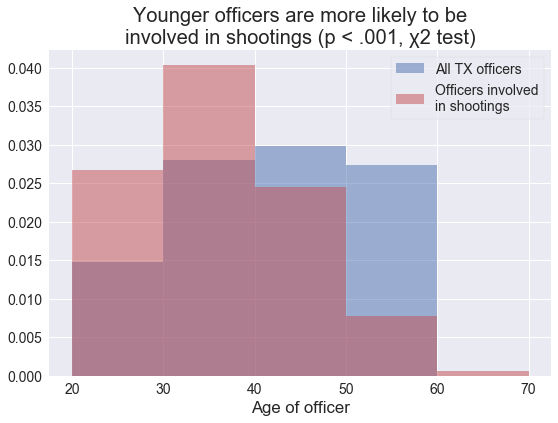

In [12]:
fig, ax = plt.subplots()
bins = np.arange(20, 71, 10)
for s, color, label in ((officer_info.age_for_plot, SNS_BLUE, LABEL_ALL),
                        (ois_officers.age, SNS_RED, LABEL_OIS)):
    s.hist(ax=ax, label=label, bins=bins, alpha=0.5, color=color, density=True)
ax.set_title('Younger officers are more likely to be\ninvolved in shootings ' + test_summary(p, chi=True))
ax.set_xlabel('Age of officer')
ax.legend()
plotsaver.saveplot(fig, 'age')

## [ Are officers of certain _genders_ disproportionately involved in shootings? ]

In [13]:
ois_officers.groupby('age_range')['is_male'].mean()

age_range
21-30    0.954545
31-40    0.961686
41-50    0.980892
51+      1.000000
Name: is_male, dtype: float64

In [14]:
officer_info.groupby('age_range')['is_male'].mean()

age_range
21-30    0.830546
31-40    0.859970
41-50    0.883563
51+      0.912637
Name: is_male, dtype: float64

In [15]:
s1 = officer_info.gender.value_counts(True)
s1.name=LABEL_ALL
s2 = ois_officers.gender.value_counts(True)
s2.name=LABEL_OIS

# We will find that more men are involved in shootings, but above we
# also saw that younger officers are more likely to be involved.
# Since younger officers are already more likely to be male,
# the naive approach would under-report the male-ness of officers
# involved in shootings.
# We add a third bar controlling for this fact. We weight each officer
# involved in a shooting by the odds that a randomly-chosen officer their
# age would be male. If, say, 22 year old officers are 80% male, this would
# earn a weight of 1 / 0.8 = 1.25. If 100% were male, the weight would be 1.

age_male_fraction = officer_info.groupby('age_range')['is_male'].mean().sort_index()
weights = []
for age_range, gender in zip(ois_officers.age_range, ois_officers.gender):
    if pd.isnull(age_range) or pd.isnull(gender):
        weights.append(np.nan)
    else:
        if gender == 'FEMALE':
            weights.append(1.0)
        else:
            weights.append(1/age_male_fraction.loc[age_range])
ois_officers['weight'] = weights
total_weight = ois_officers['weight'].sum()
s3 = ois_officers.groupby('gender')['weight'].sum() / total_weight
s3.name = 'Same as above,\nadjusting for\ngender mix by age'

gender_df = pd.concat([s3, s2, s1], axis=1).T
gender_df = gender_df[['MALE', 'FEMALE']]
gender_df

,MALE,FEMALE
"Same as above,\nadjusting for\ngender mix by age",0.970975,0.029025
Officers involved\nin shootings,0.966374,0.033626
All TX officers,0.877113,0.122887


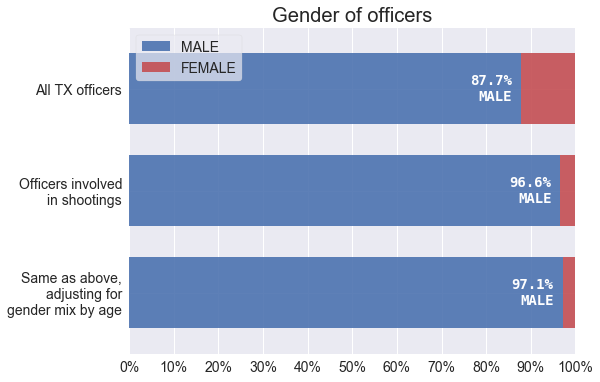

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.set_title('Gender of officers')
gender_df.plot(kind='barh', ax=ax, stacked=True, alpha=0.9, color=[SNS_BLUE, SNS_RED], width=.7)
percentify_x(ax)
ax.set_xticks(np.arange(0, 1.01, .1))
ax.set_xlim(0, 1)
ax.legend()
fontstyle = {
    'color': 'white',
    'verticalalignment': 'center',
    'weight': 'bold',
    'family': 'monospace',
    'horizontalalignment': 'right',
}
ax.text(s1.loc['MALE'] - 0.02, 2, "%.1f%%\nMALE" % (s1.loc['MALE'] * 100), fontdict=fontstyle)
ax.text(s2.loc['MALE'] - 0.02, 1, "%.1f%%\nMALE" % (s2.loc['MALE'] * 100), fontdict=fontstyle)
ax.text(s3.loc['MALE'] - 0.02, 0, "%.1f%%\nMALE" % (s3.loc['MALE'] * 100), fontdict=fontstyle)

plotsaver.saveplot(fig, 'gender')

## [ Are officers of certain _races_ disproportionately involved in shootings? ]
TODO